In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

from torchdiffeq import odeint

from src.basis_functions import OrthonormalBasis, OrthonormalLegendre1D, BSpline1D, Fourier1D, OrthonormalHermite1D
from src.velocity_functions import Func, FuncTT
from src.ode_wrapper import ContinuousNormalizingFlowODE

from utils.trajectories import plot_trajectories_over_time, plot_vector_fields_at_times
from utils.gaussian import gaussian_density

#### Implementation and training of TT-parametrized ODE flows incorporating OT Flow approach

##### Data generating functions (need to be shifted to utils)

In [45]:
# Generate 2D sample data from Gaussian
def generate_data(mean, cov, n_samples):
    # Create a multivariate normal distribution and sample
    x = torch.distributions.MultivariateNormal(mean, cov).sample((n_samples,))
    return x

In [46]:
# Generate 2D sample data from GMM
def sample_gmm(weights, components, n_samples):
    component_indices = torch.multinomial(weights, n_samples, replacement=True)
    samples = []
    for i in range(n_samples):
        component = components[component_indices[i]]
        samples.append(component.sample())
    return torch.stack(samples)

In [47]:
# Generate 2D sample data from toy distributions
def inf_train_gen(data, rng=None, n_samples=1024):
    if rng is None:
        rng = np.random.RandomState()

    if data == "swissroll":
        data = sklearn.datasets.make_swiss_roll(n_samples=n_samples, noise=1.0)[0]
        data = torch.tensor(data, dtype=torch.float32)[:, [0, 2]]
        data /= 5
        return data

    elif data == "circles":
        data = sklearn.datasets.make_circles(n_samples=n_samples, factor=.5, noise=0.08)[0]
        data = torch.tensor(data, dtype=torch.float32)
        data *= 3
        return data

    elif data == "rings":
        n_samples4 = n_samples3 = n_samples2 = n_samples // 4
        n_samples1 = n_samples - n_samples4 - n_samples3 - n_samples2

        linspace4 = np.linspace(0, 2 * np.pi, n_samples4, endpoint=False)
        linspace3 = np.linspace(0, 2 * np.pi, n_samples3, endpoint=False)
        linspace2 = np.linspace(0, 2 * np.pi, n_samples2, endpoint=False)
        linspace1 = np.linspace(0, 2 * np.pi, n_samples1, endpoint=False)

        circ4_x = np.cos(linspace4)
        circ4_y = np.sin(linspace4)
        circ3_x = np.cos(linspace3) * 0.75
        circ3_y = np.sin(linspace3) * 0.75
        circ2_x = np.cos(linspace2) * 0.5
        circ2_y = np.sin(linspace2) * 0.5
        circ1_x = np.cos(linspace1) * 0.25
        circ1_y = np.sin(linspace1) * 0.25

        X = np.vstack([
            np.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
            np.hstack([circ4_y, circ3_y, circ2_y, circ1_y])
        ]).T * 3.0
        X = util_shuffle(X, random_state=rng)
        X = X + rng.normal(scale=0.08, size=X.shape)

        return torch.tensor(X, dtype=torch.float32)

    elif data == "moons":
        data = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.1)[0]
        data = torch.tensor(data, dtype=torch.float32)
        data = data * 2 + torch.tensor([-1, -0.2], dtype=torch.float32)
        return data

    elif data == "8gaussians":
        scale = 4.0
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), 
                   (1 / np.sqrt(2), 1 / np.sqrt(2)), 
                   (1 / np.sqrt(2), -1 / np.sqrt(2)), 
                   (-1 / np.sqrt(2), 1 / np.sqrt(2)), 
                   (-1 / np.sqrt(2), -1 / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(n_samples):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return torch.tensor(dataset, dtype=torch.float32)

    elif data == "pinwheel":
        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 5
        num_per_class = n_samples // 5
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = rng.randn(num_classes * num_per_class, 2) * np.array([radial_std, tangential_std])
        features[:, 0] += 1.0
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))

        X = 2 * rng.permutation(np.einsum("ti,tij->tj", features, rotations))
        return torch.tensor(X, dtype=torch.float32)

    elif data == "2spirals":
        n = np.sqrt(np.random.rand(n_samples // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        return torch.tensor(x, dtype=torch.float32)

    elif data == "checkerboard":
        x1 = np.random.rand(n_samples) * 4 - 2
        x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, n_samples) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return torch.tensor(np.concatenate([x1[:, None], x2[:, None]], 1) * 2, dtype=torch.float32)

    elif data == "line":
        x = rng.rand(n_samples) * 5 - 2.5
        y = x
        return torch.tensor(np.stack((x, y), 1), dtype=torch.float32)

    elif data == "cos":
        x = rng.rand(n_samples) * 5 - 2.5
        y = np.sin(x) * 2.5
        return torch.tensor(np.stack((x, y), 1), dtype=torch.float32)

    else:
        return inf_train_gen("8gaussians", rng, n_samples)

In [48]:
# Sample from the GMM with 2 modes
# weights = torch.tensor([0.25, 0.25, 0.25, 0.25,])
weights = torch.tensor([0.5, 0.5])
mean1 = torch.tensor([-2.0, -2.0])  
mean2 = torch.tensor([2.0, 2.0])
# mean3 = torch.tensor([-2.0, 2.0])  
# mean4 = torch.tensor([2.0, -2.0])  

component1 = torch.distributions.MultivariateNormal(mean1, 0.1 * torch.eye(2)) 
component2 = torch.distributions.MultivariateNormal(mean2, 0.1 * torch.eye(2)) 
# component3 = torch.distributions.MultivariateNormal(mean3, 0.1 * torch.eye(2))
# component4 = torch.distributions.MultivariateNormal(mean4, 0.1 * torch.eye(2))

# components = [component1, component2, component3, component4]
components = [component1, component2]

##### Training data

In [49]:
# Training parameters
n_samples = 512
n_epochs = 10
batch_size = 64
learning_rate = 1e-3

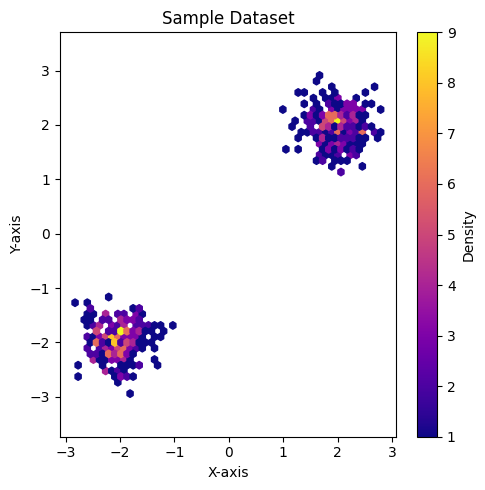

In [50]:
data = sample_gmm(weights, components, n_samples)
# data = inf_train_gen("moons", rng=None, n_samples=n_samples)

plt.figure(figsize=(5, 5))

# Create a plot for the dataset
plt.hexbin(data[:, 0], data[:, 1], gridsize=50, cmap="plasma", mincnt=1)
plt.colorbar(label='Density')
plt.title(f"Sample Dataset")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis('equal')
    
plt.tight_layout()
plt.show()

##### Define ODE flow model

Dimension: 16


Text(0.5, 1.0, 'Basis Functions 1D')

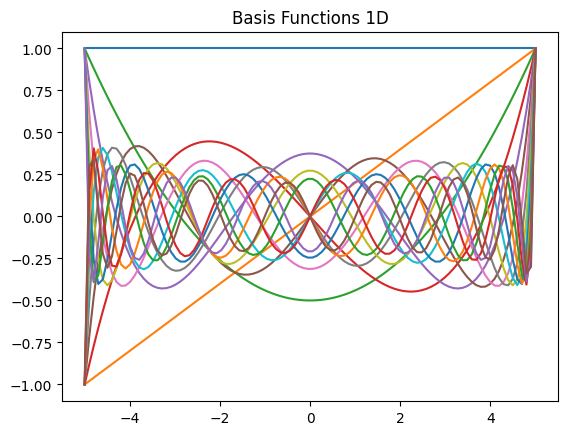

In [51]:
# Configure a Legendre basis for the FTT of the potential
dimension = 16
d = 3

bases = [
        OrthonormalLegendre1D(dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

# Visualization plot
x = np.linspace(-5., 5., 100)
y = [bases[0](torch.tensor([x[i]])).squeeze(0) for i in range(100)]
plt.plot(x, y)
plt.title("Basis Functions 1D")

In [56]:
# Configure a Legendre basis for the FTT in layer 1 for the potential
dimension_layer1 = 8
d_in = 2

bases_layer1 = [
        OrthonormalLegendre1D(dimension_layer1, domain=(-5., 5.))
        for _ in range(d_in + 1)
        ]
print(f"Dimension layer 1: {bases_layer1[0].dimension}")

# Configure a Legendre basis for the FTT in layer 2 for the potential
dimension_layer2 = 8
d_out = 8

bases_layer2 = [
        OrthonormalLegendre1D(dimension_layer2, domain=(-5., 5.))
        for _ in range(d_out)
        ]
print(f"Dimension layer 2: {bases_layer2[0].dimension}")

Dimension layer 1: 8
Dimension layer 2: 8


##### TT-parametrized ODE systems for density estimation (need to be shifted to src)

In [41]:
class PotentialTTShallow(nn.Module):
    def __init__(self, d_in: int, d_out: int, bases: list, tt_rank: int, matrix_rank: int, **kwargs):
        super().__init__(**kwargs)
        assert len(bases) == d_in + 1
        self.d_in = d_in
        self.d_out = d_out
        self.bases = bases
        self.matrix_rank = matrix_rank
        self.ranks_layer1 = [1] + [tt_rank] * d_in + [d_out]
        self.dims = [basis.dimension for basis in bases]

        # Initialize all learnable parameters
        # TT cores
        self.size = np.sum(np.asarray(self.ranks[:-1]) * np.asarray(self.dims) * np.asarray(self.ranks[1:]))
        self.tt_cores = nn.ParameterList(
            [nn.Parameter(torch.randn(self.ranks[i], self.dims[i], self.ranks[i+1]).to(torch.float32) / torch.sqrt(torch.tensor(self.size, dtype=torch.float32)))
                for i in range(len(self.dims))
            ]
        )
        # Initialize further learnable parameters
        self.w = nn.Parameter(
            torch.randn(self.d_out).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.d_out, dtype=torch.float32))
        )
        self.A = nn.Parameter(
            torch.randn(self.matrix_rank, self.d_in + 1).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.matrix_rank * (self.d_in + 1), dtype=torch.float32))
        )
        self.b = nn.Parameter(
            torch.randn(self.d_in + 1).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.d_in + 1, dtype=torch.float32))
        )
        self.c = nn.Parameter(
            torch.randn(1).to(torch.float32)
        )

    def eval_ftt(self, t: float, x: torch.Tensor):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [basis(input_with_time[:, i]) for i, basis in enumerate(self.bases)]

        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def eval(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate quadratic potentials
        quadratic_term = torch.tensor(0.5) * input_with_time.T @ (self.A.T @ self.A) @ input_with_time + self.b.T @ input_with_time + self.c
        # Return potentials
        return self.w.T @ self.eval_ftt(t, x) + quadratic_term

    def partial_ftt(self, t: float, x: torch.Tensor, var_index: int):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            basis(input_with_time[:, i], m_derivative=1) if i == var_index else basis(input_with_time[:, i], m_derivative=0) 
            for i, basis in enumerate(self.bases)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def grad_ftt(self, t: float, x: torch.Tensor):
        # Stack all partial derivatives w.r.t. variable x to obtain gradient
        partials = [self.partial_ftt(t, x, i) for i in range(1, x.shape[0] + 1, 1)]
        
        return torch.stack(partials, dim=0)
    
    def partial_t(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate linear dynamics
        linear_term = (self.A.T @ self.A) @ input_with_time + self.b
        # Return partial derivative w.r.t. variable t
        return self.partial_ftt(t, x, 0) @  self.w + linear_term[0]

    def grad(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate linear dynamics
        linear_term = (self.A.T @ self.A) @ input_with_time + self.b
        # Return gradient
        return self.grad_ftt(t, x) @ self.w + linear_term[1:]
    
    def second_partial_ftt(self, t: float, x: torch.Tensor, var_index: tuple):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            # Logic to calculate first/second order derivatives of basis functions
            basis(input_with_time[:, i], m_derivative=2) if i in var_index and len(set(var_index)) == 1
            else basis(input_with_time[:, i], m_derivative=1) if i in var_index and len(set(var_index)) == 2
            else basis(input_with_time[:, i], m_derivative=0)
            for i, basis in enumerate(self.bases)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores[k].float(), bases_eval[k].float())
        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        return result
    
    def hessian_ftt(self, t: float, x: torch.Tensor):
        # Calculate Hessian of FTT
        second_partials = []
        for j in range(1, x.shape[0] + 1, 1):
            second_partials_i = torch.stack([self.second_partial_ftt(t, x, var_index=(i, j)) @ self.w for i in range(1, x.shape[0] + 1, 1)], dim=0)
            second_partials.append(second_partials_i)
        hessian_ftt = torch.stack(second_partials, dim=0)
        return hessian_ftt
    
    def hessian(self, t: float, x: torch.Tensor):
        # Calculate the Hessian of the potential
        const = self.A.T @ self.A
        return self.hessian_ftt(t, x) + const[1:,1:]

##### Developing TT-parametrized potential in ResNet structure

In [57]:
class PotentialTTResNet(nn.Module):
    def __init__(self, d_in: int, d_out: int, bases_layer1: list, bases_layer2: list, tt_rank_layer1: int, tt_rank_layer2: int, matrix_rank: int, step_h=1., **kwargs):
        super().__init__(**kwargs)
        assert len(bases_layer1) == d_in + 1
        assert len(bases_layer2) == d_out
        self.d_in = d_in
        self.d_out = d_out
        self.bases_layer1 = bases_layer1
        self.bases_layer2 = bases_layer2
        self.matrix_rank = matrix_rank
        self.ranks_layer1 = [1] + [tt_rank_layer1] * d_in + [d_out]
        self.ranks_layer2 = [1] + [tt_rank_layer2] * (d_out - 1) + [d_out]
        self.dims_layer1 = [basis.dimension for basis in bases_layer1]
        self.dims_layer2 = [basis.dimension for basis in bases_layer2]
        self.step_h = step_h

        # Initialize all learnable parameters
        # TT cores layer 1
        self.size_layer1 = np.sum(np.asarray(self.ranks_layer1[:-1]) * np.asarray(self.dims_layer1) * np.asarray(self.ranks_layer1[1:]))
        self.tt_cores_layer1 = nn.ParameterList(
            [nn.Parameter(torch.randn(self.ranks_layer1[i], self.dims_layer1[i], self.ranks_layer1[i+1]).to(torch.float32) / torch.sqrt(torch.tensor(self.size_layer1, dtype=torch.float32)))
                for i in range(len(self.dims_layer1))
            ]
        )
        # TT cores layer 2
        self.size_layer2 = np.sum(np.asarray(self.ranks_layer2[:-1]) * np.asarray(self.dims_layer2) * np.asarray(self.ranks_layer2[1:]))
        self.tt_cores_layer2 = nn.ParameterList(
            [nn.Parameter(torch.randn(self.ranks_layer2[i], self.dims_layer2[i], self.ranks_layer2[i+1]).to(torch.float32) / torch.sqrt(torch.tensor(self.size_layer2, dtype=torch.float32)))
                for i in range(len(self.dims_layer2))
            ]
        )
        # Initialize further learnable parameters
        self.w = nn.Parameter(
            torch.randn(self.d_out).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.d_out, dtype=torch.float32))
        )
        self.A = nn.Parameter(
            torch.randn(self.matrix_rank, self.d_in + 1).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.matrix_rank * (self.d_in + 1), dtype=torch.float32))
        )
        self.b = nn.Parameter(
            torch.randn(self.d_in + 1).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.d_in + 1, dtype=torch.float32))
        )
        self.c = nn.Parameter(
            torch.randn(1).to(torch.float32)
        )

    # Evaluating (components) of the potential function
    def eval_ftt_layer1(self, t: float, x: torch.Tensor):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [basis(input_with_time[:, i]) for i, basis in enumerate(self.bases_layer1)]

        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores_layer1[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def eval_ftt_layer2(self, x: torch.Tensor):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        # t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        # input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [basis(x[:, i]) for i, basis in enumerate(self.bases_layer2)]

        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores_layer2[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result

    def eval_ctt(self, t: float, x: torch.Tensor):
        # Evaluate CTT with 2 layer ResNet structure 
        result_layer1 = self.eval_ftt_layer1(t, x)
        result_layer2 = result_layer1 # + torch.tensor(self.step_h) * self.eval_ftt_layer2(result_layer1)

        return result_layer2
    
    def eval(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate quadratic potentials
        quadratic_term = torch.tensor(0.5) * input_with_time.T @ (self.A.T @ self.A) @ input_with_time + self.b.T @ input_with_time + self.c
        # Return potentials
        return self.w.T @ self.eval_ctt(t, x) # + quadratic_term
    
    # Evaluating partial derivatives and gradients
    def partial_ftt_layer1(self, t: float, x: torch.Tensor, var_index: int):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            basis(input_with_time[:, i], m_derivative=1) if i == var_index else basis(input_with_time[:, i], m_derivative=0) 
            for i, basis in enumerate(self.bases_layer1)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores_layer1[k].float(), bases_eval[k].float())
        
        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def partial_ftt_layer2(self, x: torch.Tensor, var_index: int):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        # t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        # input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            basis(x[:, i], m_derivative=1) if i == var_index else basis(x[:, i], m_derivative=0) 
            for i, basis in enumerate(self.bases_layer2)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores_layer2[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def grad_ftt_layer1(self, t: float, x: torch.Tensor):
        # Stack all partial derivatives w.r.t. variable x to obtain gradient
        partials = [self.partial_ftt_layer1(t, x, i) for i in range(1, x.shape[-1] + 1, 1)]
        
        return torch.stack(partials, dim=0)
    
    def grad_ftt_layer2(self, x: torch.Tensor):
        # Stack all partial derivatives w.r.t. variable x to obtain gradient
        partials = [self.partial_ftt_layer2(x, i) for i in range(1, x.shape[-1] + 1, 1)]
        
        return torch.stack(partials, dim=0)
    
    def grad_ctt(self, t: float, x: torch.Tensor):
        # Evaluating gradient of CTT with 2 layer ResNet structure - for testing purpose
        # result_layer1 = self.eval_ftt_layer1(t, x)
        grad_ftt_layer1 = self.grad_ftt_layer1(t, x)
        # grad_ftt_layer2 = self.grad_ftt_layer2(result_layer1)
        
        return grad_ftt_layer1 # + self.step_h * grad_ftt_layer1 @ grad_ftt_layer2

    def partial_t(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate linear dynamics
        # linear_term = (self.A[:,0].T @ self.A) @ input_with_time + self.b[0]
        # Calculate partial derivative w.r.t. t and gradients
        # result_layer1 = self.eval_ftt_layer1(t, x)
        partial_t_ftt_layer1 = self.partial_ftt_layer1(t, x, 0)
        # grad_ftt_layer2 = self.grad_ftt_layer2(result_layer1)
        # Return partial derivative w.r.t. variable t
        result =  partial_t_ftt_layer1 @  self.w # + self.step_h * partial_t_ftt_layer1 @ grad_ftt_layer2 @  self.w # + linear_term
        
        return result

    def grad(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate linear dynamics
        # linear_term = (self.A[:,1:].T @ self.A) @ input_with_time + self.b[1:]
        # Calculate gradients
        # result_layer1 = self.eval_ftt_layer1(t, x)
        grad_ftt_layer1 = self.grad_ftt_layer1(t, x)
        # grad_ftt_layer2 = self.grad_ftt_layer2(result_layer1)
        # Return partial derivative w.r.t. variable t
        result =  grad_ftt_layer1 @ self.w # + self.step_h * grad_ftt_layer1 @ grad_ftt_layer2 @  self.w # + linear_term
        
        return result
    
    def second_partial_ftt_layer1(self, t: float, x: torch.Tensor, var_index: tuple):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            # Logic to calculate first/second order derivatives of basis functions
            basis(input_with_time[:, i], m_derivative=2) if i in var_index and len(set(var_index)) == 1
            else basis(input_with_time[:, i], m_derivative=1) if i in var_index and len(set(var_index)) == 2
            else basis(input_with_time[:, i], m_derivative=0)
            for i, basis in enumerate(self.bases_layer1)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores_layer1[k].float(), bases_eval[k].float())
        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        return result

    def second_partial_ftt_layer2(self, x: torch.Tensor, var_index: tuple):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        # t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        # input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            # Logic to calculate first/second order derivatives of basis functions
            basis(x[:, i], m_derivative=2) if i in var_index and len(set(var_index)) == 1
            else basis(x[:, i], m_derivative=1) if i in var_index and len(set(var_index)) == 2
            else basis(x[:, i], m_derivative=0)
            for i, basis in enumerate(self.bases_layer2)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores_layer2[k].float(), bases_eval[k].float())
        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        return result

    def hessian_ftt_layer1_w(self, t: float, x: torch.Tensor, w: torch.Tensor):
        # Calculate Hessian of FTT layer 1 times vector w
        second_partials = []
        for j in range(1, x.shape[0] + 1, 1):
            second_partials_i = torch.stack([self.second_partial_ftt_layer1(t, x, var_index=(i, j)) @ w for i in range(1, x.shape[0] + 1, 1)], dim=0)
            second_partials.append(second_partials_i)
        result = torch.stack(second_partials, dim=0)

        return result
    
    def hessian_ftt_layer2_w(self, x: torch.Tensor, w: torch.Tensor):
        # Calculate Hessian of FTT layer 2 times vector w
        second_partials = []
        for j in range(1, x.shape[0] + 1, 1):
            second_partials_i = torch.stack([self.second_partial_ftt_layer2(x, var_index=(i, j)) @ w for i in range(1, x.shape[0] + 1, 1)], dim=0)
            second_partials.append(second_partials_i)
        result = torch.stack(second_partials, dim=0)

        return result
    
    def hessian_ctt_w(self, t: float, x: torch.Tensor, w: torch.Tensor):
        # Calculate Hessian of CTT times vector w
        # eval_ftt_layer1 = self.eval_ftt_layer1(t, x)
        # grad_ftt_layer1 = self.grad_ftt_layer1(t, x)
        # grad_ftt_layer2_w = self.grad_ftt_layer2(eval_ftt_layer1) @ w
        # hessian_ftt_layer1_grad_ftt_layer2_w = self.hessian_ftt_layer1_w(t, x, grad_ftt_layer2_w)
        # hessian_ftt_layer2_w = self.hessian_ftt_layer2_w(eval_ftt_layer1, w)

        result = self.hessian_ftt_layer1_w(t, x, w) # + self.step_h * (hessian_ftt_layer1_grad_ftt_layer2_w + grad_ftt_layer1 @ hessian_ftt_layer2_w @ grad_ftt_layer1.T)
        
        return result
    
    def hessian(self, t: float, x: torch.Tensor):
        # Calculate Hessian of the potential function
        # const = self.A.T @ self.A
        result = self.hessian_ctt_w(t, x, self.w) # + const[1:, 1:]
        
        return result

##### Various Tests for the implementation of the potential

In [114]:
# Configure a Legendre basis
dimension_layer1 = 8
d_in = 2

bases_layer1 = [
        OrthonormalLegendre1D(dimension_layer1, domain=(-5., 5.))
        for _ in range(d_in + 1)
        ]
print(f"Dimension layer 1: {bases_layer1[0].dimension}")

dimension_layer2 = 8
d_out = 2

bases_layer2 = [
        OrthonormalLegendre1D(dimension_layer2, domain=(-5., 5.))
        for _ in range(d_out)
        ]
print(f"Dimension layer 2: {bases_layer2[0].dimension}")

Dimension layer 1: 8
Dimension layer 2: 8


In [115]:
potential = PotentialTTResNet(
    d_in=2, 
    d_out=2, 
    bases_layer1=bases_layer1, 
    bases_layer2=bases_layer2, 
    tt_rank_layer1=8,
    tt_rank_layer2=8,
    matrix_rank=2
)

In [116]:
print(potential.A)
print(potential.tt_cores_layer1)

Parameter containing:
tensor([[-0.7123, -0.2932, -0.1439],
        [-0.3164, -0.4715, -0.3443]], requires_grad=True)
ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x8x8]
    (1): Parameter containing: [torch.float32 of size 8x8x8]
    (2): Parameter containing: [torch.float32 of size 8x8x2]
)


In [117]:
# Test TT-ResNet
x = torch.tensor([0., 0.])
print(potential.eval_ctt(0.5, x))
print(potential.eval_ftt_layer1(0.5, x) + 1 * potential.eval_ftt_layer2(potential.eval_ftt_layer1(0.5, x)))

tensor([-0.0119,  0.0118], grad_fn=<AddBackward0>)
tensor([-0.0119,  0.0118], grad_fn=<AddBackward0>)


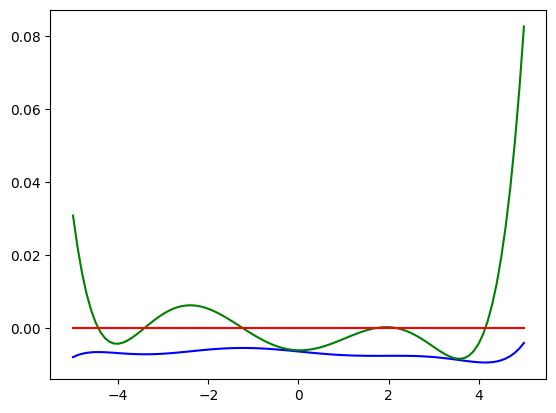

In [118]:
# Test partial derivative of potential w.r.t. t
x = torch.linspace(-5., 5., 100)
t = torch.linspace(-5., 5., 100)
y = [potential.eval(t[i], torch.tensor([0., 0.])).detach().numpy() for i in range(100)]
z = [potential.partial_t(t[i], torch.tensor([0., 0.])).detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, np.zeros(100), color='red')

In [119]:
potential.grad(0., torch.tensor([0., 0.]))

tensor([-0.0028, -0.0006], grad_fn=<AddBackward0>)

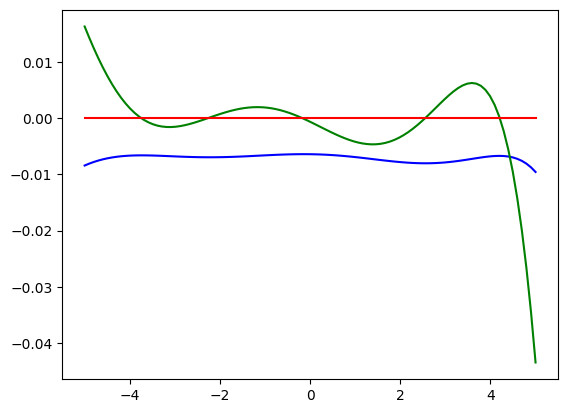

In [120]:
# Test partial derivative of potential w.r.t. x_i
x = torch.linspace(-5., 5., 100)
t = torch.linspace(-5., 5., 100)
y = [potential.eval(0., torch.concat((torch.tensor([0.]), torch.tensor([x[i]])))).detach().numpy() for i in range(100)]
z = [potential.grad(0., torch.concat((torch.tensor([0.]), torch.tensor([x[i]]))))[1].detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, np.zeros(100), color='red')

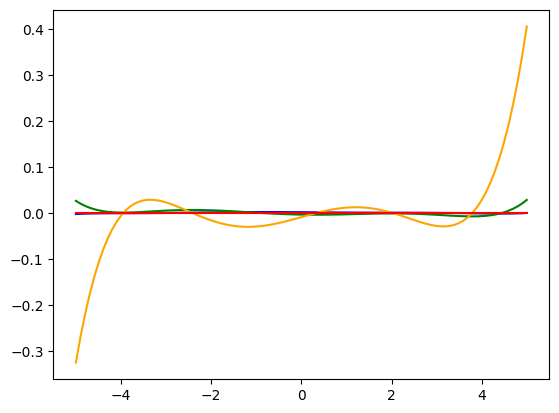

In [121]:
# Test second order partial derivative of ftt w.r.t. t/x_i
x = torch.linspace(-5, 5., 100)
t = torch.linspace(-5, 5., 100)
y = [potential.eval_ftt_layer1(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[1].detach().numpy() for i in range(100)]
z = [potential.partial_ftt_layer1(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), 1)[1].detach().numpy() for i in range(100)]
w = [potential.second_partial_ftt_layer1(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), (1, 1))[1].detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, w, color='orange')
plt.plot(x, np.zeros(100), color='red')

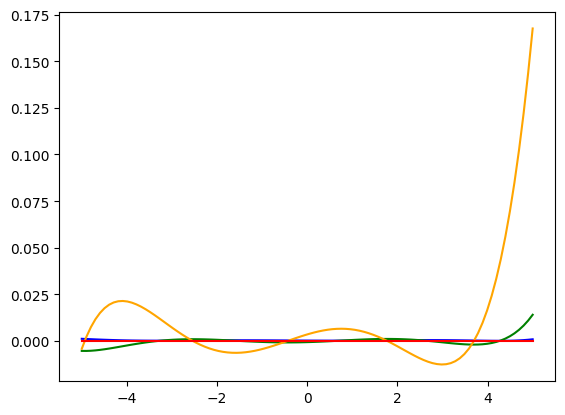

In [122]:
# Test second order partial derivative of ftt layer 1 w.r.t. t/x_i and hessian times w
x = torch.linspace(-5., 5., 100)
t = torch.linspace(-5., 5., 100)
y = [potential.eval_ftt_layer1(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[0].detach().numpy() for i in range(100)]
z = [potential.partial_ftt_layer1(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), 1)[0].detach().numpy() for i in range(100)]
# w = [potential.second_partial_ftt_layer1(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), (1, 1))[0].detach().numpy() for i in range(100)]
w = [potential.hessian_ftt_layer1_w(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), torch.tensor([1., 0.]))[0, 0].detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, w, color='orange')
plt.plot(x, np.zeros(100), color='red')

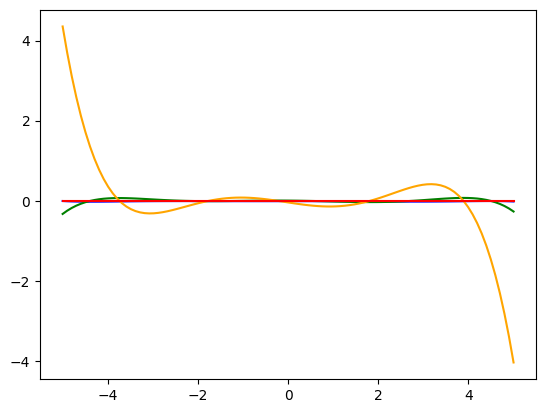

In [123]:
# Test second order partial derivative of ftt layer 2 w.r.t. t/x_i and hessian times w
x = torch.linspace(-5., 5., 100)
t = torch.linspace(-5., 5., 100)
y = [potential.eval_ftt_layer2(torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[0].detach().numpy() for i in range(100)]
z = [potential.partial_ftt_layer2(torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), 0)[0].detach().numpy() for i in range(100)]
w = [potential.second_partial_ftt_layer2(torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), (0, 0))[0].detach().numpy() for i in range(100)]
# w = [potential.hessian_ftt_layer2_w(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), torch.tensor([1., 0.]))[0, 0].detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, w, color='orange')
plt.plot(x, np.zeros(100), color='red')

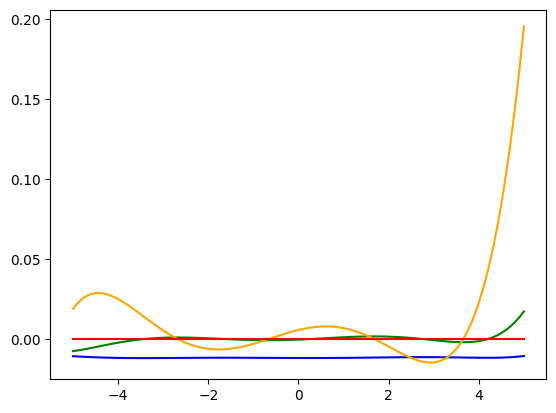

In [124]:
# Test second order partial derivative of ctt w.r.t. t/x_i and hessian times w
x = torch.linspace(-5., 5., 100)
t = torch.linspace(-5., 5., 100)
y = [potential.eval_ctt(0.5, torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[0].detach().numpy() for i in range(100)]
z = [potential.grad_ctt(0.5, torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[0, 0].detach().numpy() for i in range(100)]
w = [potential.hessian_ctt_w(0.5, torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), torch.tensor([1., 0.]))[0, 0].detach().numpy() for i in range(100)]
# w = [potential.hessian_ftt_layer2_w(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), torch.tensor([1., 0.]))[0, 0].detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, w, color='orange')
plt.plot(x, np.zeros(100), color='red')

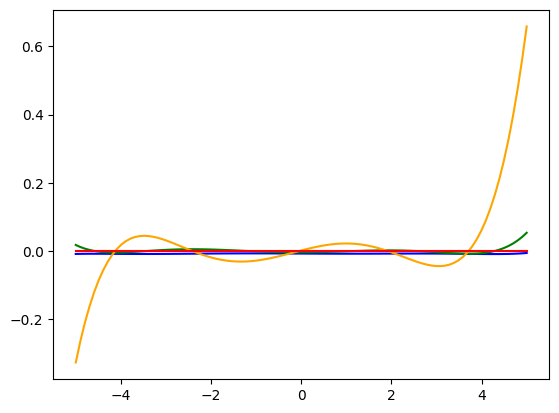

In [125]:
# Test second order partial derivative of potential function w.r.t. t/x_i and hessian times w
x = torch.linspace(-5., 5., 100)
t = torch.linspace(-5., 5., 100)
y = [potential.eval(0.5, torch.concat((torch.tensor([x[i]]), torch.tensor([0.])))).detach().numpy() for i in range(100)]
z = [potential.grad(0.5, torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[0].detach().numpy() for i in range(100)]
w = [potential.hessian(0.5, torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))))[0, 0].detach().numpy() for i in range(100)]
# w = [potential.hessian_ftt_layer2_w(0., torch.concat((torch.tensor([x[i]]), torch.tensor([0.]))), torch.tensor([1., 0.]))[0, 0].detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, w, color='orange')
plt.plot(x, np.zeros(100), color='red')

##### Integrating potential in ODE system

In [58]:
# TT-parametrized ODE system for density estimation inspired by the continuous normalizing flow formulation in Chen et al. 2018,
# implemented based on the OT-Flow approach from Onken et al. 2021
class ContinuousNormalizingFlowODEDensityEstimationOTFlow(nn.Module):
    def __init__(self, potential, **kwargs):
        super().__init__(**kwargs)
        self.potential = potential # Function defining the potential driving the flow
        self.transport_cost = None
        self.trace_integral = None
        self.hjb_integral = None

    # Incorporated instantaneous change of variables formula
    def forward(self, t: float, state: torch.Tensor) -> torch.Tensor:
        """
        To be adapted: 
        Compute the derivatives dx/dt, dz/dt, and dl/dt for the ODE system.
        This includes:
        - dx/dt = func(t, x)
        - dz/dt = ||func(t, x)||_2^2 (kinetic energy)
        - dl/dt = tr(Jacobian(func(t, x))) (log det of the Jacobian, trace estimated via Monte-Carlo)
        - dg/dt = ||Jacobian(func(t, x))||_2^2 (integral of the Frobenius norm of the Jacobian, norm estimated via Monte-Carlo)
        """
        x = state[:-3]  # Extract x(t) from the state
        z = state[-3]   # Extract z(t) from the state
        l = state[-2]   # Extract l(t) from the state
        g = state[-1]   # Extract g(t) from the state
        dxdt = - self.potential.grad(t, x)
        dzdt = 0.5 * torch.norm(dxdt, p=2) ** 2

        dldt = - torch.trace(self.potential.hessian(t, x))
        drdt = torch.abs(self.potential.partial_t(t, x) - 0.5 * torch.norm(dxdt, p=2) ** 2)

        return torch.clip(torch.cat([dxdt, dzdt.unsqueeze(0), dldt.unsqueeze(0), drdt.unsqueeze(0)], dim=0), min=-1e1, max=1e1)

    def solve_ode(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE for a given initial condition and time steps."""
        # Appended the initial transport cost (z(0) = 0) to the state
        y0_with_z_l_and_r = torch.cat([y0, torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype)], dim=0)
        solution = odeint(self.forward, y0_with_z_l_and_r, ts, rtol=rtol, atol=atol, method=method)
        
        if torch.isnan(solution).any() or torch.isinf(solution).any():
            print("Warning: Instable velocity field")
        
        return solution

    def evaluate_final_state(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE and return the final state, transport cost, trace integral and gradient norm integral."""
        solution = self.solve_ode(y0, ts, rtol, atol, method)
        # Extract the final state, transport cost, trace integral, and gradient norm integral
        final_state = solution[-1, :-3]
        transport_cost = solution[-1, -3]  
        trace_integral = solution[-1, -2]
        hjb_integral = solution[-1, -1]
        return final_state, transport_cost, trace_integral, hjb_integral

    # Solve ODE backward in time
    def solve_ode_backward(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE backward in time."""
        # Reverse the time vector for backward integration
        ts_backward = torch.flip(ts, dims=[0])
        # Solve the ODE starting from the final state y0 at ts[-1]
        def velocity_func(t, x):
            return - self.potential.grad(t, x)

        solution = odeint(velocity_func, y0, ts_backward, rtol=rtol, atol=atol, method=method)
        return solution[-1, :]
        
    def __call__(self, y0: torch.Tensor, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                 rtol=1e-3, atol=1e-6, method='euler', backward=False) -> torch.Tensor:
        """Main method to solve the ODE for batches or single initial conditions."""
        if backward:  # Solve ODE backward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                for i in range(y0.shape[0]):
                    final_state = self.solve_ode_backward(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state = self.solve_ode_backward(y0, ts, rtol, atol, method)
                return final_state
        else:  # Solve ODE foward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                transport_costs = []
                trace_integrals = []
                hjb_integrals = []
                for i in range(y0.shape[0]):
                    final_state, transport_cost, trace_integral, hjb_integral = self.evaluate_final_state(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                    transport_costs.append(transport_cost)
                    trace_integrals.append(trace_integral)
                    hjb_integrals.append(hjb_integral)
                self.transport_cost = torch.stack(transport_costs)
                self.trace_integral = torch.stack(trace_integrals)
                self.hjb_integral = torch.stack(hjb_integrals)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state, transport_cost, trace_integral, hjb_integral = self.evaluate_final_state(y0, ts, rtol, atol, method)
                self.transport_cost = transport_cost
                self.trace_integral = trace_integral
                self.hjb_integral = hjb_integral
                return final_state

##### Model training

In [59]:
# potential_rank16 = PotentialTTShallow(d_in=2, d_out=16, bases=bases, tt_rank=16, matrix_rank=16)
# model_rank16_ot_flow = ContinuousNormalizingFlowODEDensityEstimationOTFlow(potential_rank16)

potential = PotentialTTResNet(
    d_in=2, 
    d_out=8, 
    bases_layer1=bases_layer1,
    bases_layer2=bases_layer2,
    tt_rank_layer1=8,
    tt_rank_layer2=8,
    matrix_rank=8
)

model_ot_flow = ContinuousNormalizingFlowODEDensityEstimationOTFlow(potential)

# Set the models to training mode and choose optimizer
model_ot_flow.train()

# Test
x = torch.tensor([[0., 0.], [0.5, 0.5], [1., 1.]])
# x = torch.tensor([0., 0.])
y = model_ot_flow(x)
y

tensor([[-5.8829e-04, -3.7373e-04],
        [ 4.9935e-01,  4.9990e-01],
        [ 9.9975e-01,  1.0006e+00]], grad_fn=<StackBackward0>)

In [60]:
# Now, create the optimizer with the parameters of the potential
optimizer_ot_flow = optim.AdamW(model_ot_flow.parameters(), lr=learning_rate)

# Norm of TT cores / other parameters
print(f"Norm TT-cores layer 1: {sum(torch.norm(core, p='fro') for core in model_ot_flow.potential.tt_cores_layer1)}")
print(f"Norm TT-cores layer 2: {sum(torch.norm(core, p='fro') for core in model_ot_flow.potential.tt_cores_layer2)}")
print(f"Norm w: {torch.norm(model_ot_flow.potential.w, p='fro')}")
print(f"Norm A: {torch.norm(model_ot_flow.potential.A, p='fro')}")
print(f"Norm b: {torch.norm(model_ot_flow.potential.b, p='fro')}")
print(f"Norm c: {torch.norm(model_ot_flow.potential.c, p='fro')}")

Norm TT-cores layer 1: 1.6140294075012207
Norm TT-cores layer 2: 2.8237011432647705
Norm w: 0.8030217885971069
Norm A: 1.2613976001739502
Norm b: 1.135608196258545
Norm c: 0.8831014037132263


In [61]:
model_ot_flow.parameters

<bound method Module.parameters of ContinuousNormalizingFlowODEDensityEstimationOTFlow(
  (potential): PotentialTTResNet(
    (tt_cores_layer1): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x8x8]
        (1): Parameter containing: [torch.float32 of size 8x8x8]
        (2): Parameter containing: [torch.float32 of size 8x8x8]
    )
    (tt_cores_layer2): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x8x8]
        (1): Parameter containing: [torch.float32 of size 8x8x8]
        (2): Parameter containing: [torch.float32 of size 8x8x8]
        (3): Parameter containing: [torch.float32 of size 8x8x8]
        (4): Parameter containing: [torch.float32 of size 8x8x8]
        (5): Parameter containing: [torch.float32 of size 8x8x8]
        (6): Parameter containing: [torch.float32 of size 8x8x8]
        (7): Parameter containing: [torch.float32 of size 8x8x8]
    )
  )
)>

In [62]:
# Loss function for sample-based density estimation
def loss_func(model, x: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg, lambda_hjb_reg):
    
    lambda_likelihood = 1e-1

    y_pred = model(x, ts, rtol, atol, method, backward)
    
    l2_transport_cost = model.transport_cost
    log_det_gradient_func = model.trace_integral
    hjb_regularization = model.hjb_integral
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.potential.tt_cores_layer1) + sum(torch.norm(core, p="fro") for core in model.potential.tt_cores_layer2)
    
    p_y_pred = gaussian_density(y_pred, torch.eye(2) * 1., True)
    loss = lambda_likelihood * (- torch.log(torch.clip(p_y_pred, min=1e-8)) - log_det_gradient_func) + lambda_transport_reg * l2_transport_cost + lambda_hjb_reg * hjb_regularization
    
    return loss.mean() + lambda_tt_reg * tt_regularization

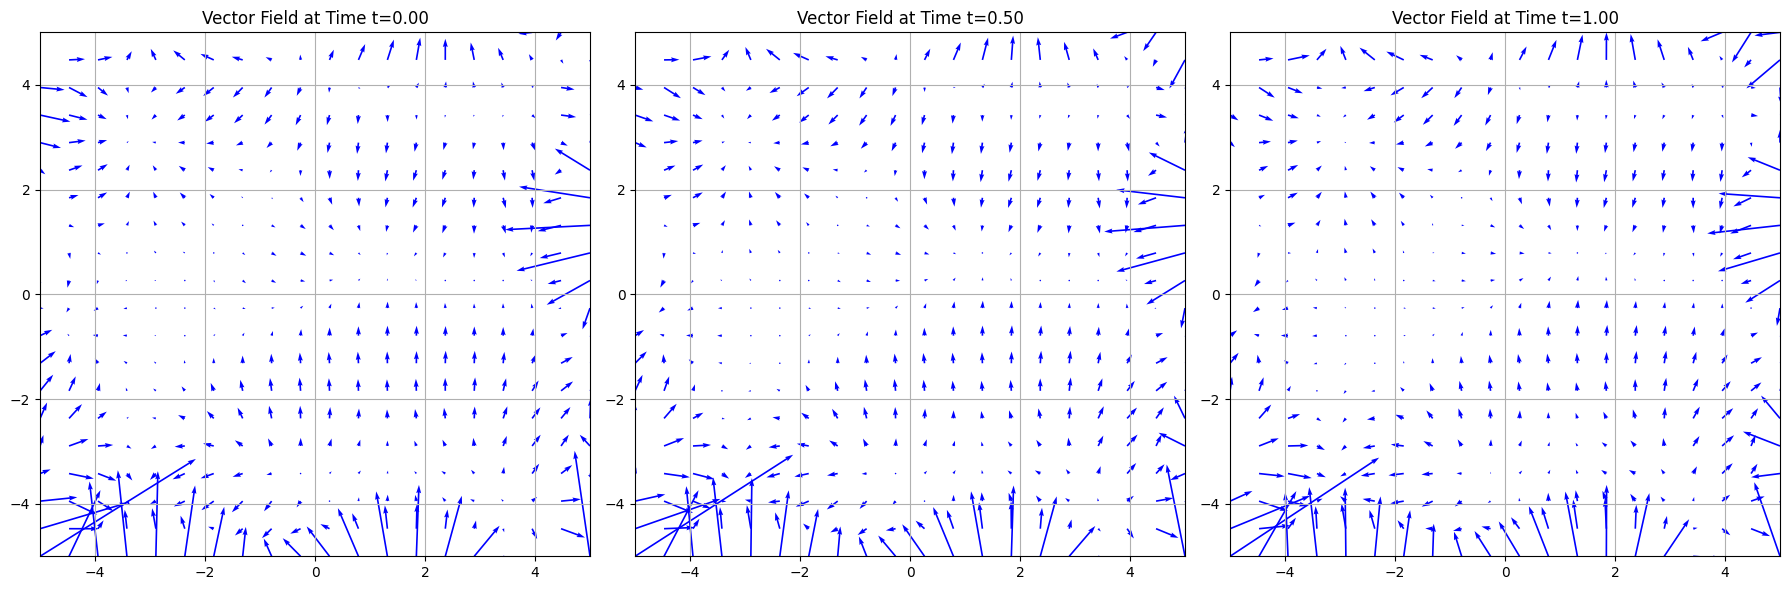

In [63]:
# Plot ODE flow vector field in various points in time before training
plot_vector_fields_at_times(model_ot_flow.potential.grad, x_range = (-5., 5.), y_range = (-5., 5.), plot_time = torch.tensor([0.0, 0.5, 1.0]))

In [64]:
print(f"w: {model_ot_flow.potential.w}")
print(f"A: {model_ot_flow.potential.A}")
print(f"b: {model_ot_flow.potential.b}")
print(f"c: {model_ot_flow.potential.c}")
print(f"TT-cores layer1: {model_ot_flow.potential.tt_cores_layer1}")
print(f"TT-cores layer 2: {model_ot_flow.potential.tt_cores_layer2}")

w: Parameter containing:
tensor([ 0.2009, -0.1546,  0.4896, -0.3976,  0.0688,  0.1521, -0.2695, -0.2869],
       requires_grad=True)
A: Parameter containing:
tensor([[-0.1496,  0.1568,  0.2972],
        [-0.2720,  0.1735,  0.1500],
        [ 0.3658, -0.5282, -0.1174],
        [ 0.3333,  0.1275, -0.4082],
        [-0.0767,  0.3572,  0.2496],
        [-0.3455,  0.0400,  0.1702],
        [ 0.1064,  0.0991,  0.0408],
        [ 0.4578,  0.0128, -0.1744]], requires_grad=True)
b: Parameter containing:
tensor([-0.6346,  0.9066,  0.2549], requires_grad=True)
c: Parameter containing:
tensor([-0.8831], requires_grad=True)
TT-cores layer1: ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x8x8]
    (1): Parameter containing: [torch.float32 of size 8x8x8]
    (2): Parameter containing: [torch.float32 of size 8x8x8]
)
TT-cores layer 2: ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x8x8]
    (1): Parameter containing: [torch.float32 of size 8x8x8]
    (2): 

In [65]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-0, lambda_tt_reg = 1e-3, lambda_hjb_reg = 1e-1):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Variable to track if learning rate had been reduced
    # reduced_lr = False
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0

        # Reduce lambda_tt_reg
        # lambda_transport_reg *= 1 / (10 ** (1/10))
        # lambda_tt_reg *= 1 / (10 ** (1/10))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg, lambda_hjb_reg)
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            
            # Perform the optimizer step
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Compute norm of TT cores after the epoche
        norm_tt_cores = sum(torch.norm(core, p="fro") for core in model.potential.tt_cores_layer1) + sum(torch.norm(core, p="fro") for core in model.potential.tt_cores_layer2)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Reduce learning rate to ensure convergence
        # if (epoch +1) % 10 == 0: # and not reduced_lr:
        #     lr = optimizer.param_groups[0]['lr'] * 1e-1 
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr  
        #         reduced_lr = True
        #     print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}, "
                  f"HJB Regularizer: {model.hjb_integral.mean():.4f}, "
                  f"TT Cores Norm: {norm_tt_cores:.4f}"
            )
            
    training_dict[training_id] = loss_history

In [88]:
n_epochs = 30

In [98]:
training_dict = {}

training_procedure(model_ot_flow, data, batch_size, n_epochs, optimizer_ot_flow, training_dict, "ResNet OT flow", ts = torch.tensor(np.linspace(0., 1., 4)))


Training Run ID: ResNet OT flow

Epoch [1/30], Loss: -0.1443, Transport Cost: 0.1827, HJB Regularizer: 0.1247, TT Cores Norm: 4.0901
Epoch [2/30], Loss: -0.1447, Transport Cost: 0.1718, HJB Regularizer: 0.1121, TT Cores Norm: 4.0949
Epoch [3/30], Loss: -0.1446, Transport Cost: 0.1863, HJB Regularizer: 0.1291, TT Cores Norm: 4.1081
Epoch [4/30], Loss: -0.1459, Transport Cost: 0.1818, HJB Regularizer: 0.1251, TT Cores Norm: 4.1286
Epoch [5/30], Loss: -0.1461, Transport Cost: 0.2092, HJB Regularizer: 0.1314, TT Cores Norm: 4.1359
Epoch [6/30], Loss: -0.1471, Transport Cost: 0.1783, HJB Regularizer: 0.1218, TT Cores Norm: 4.1483
Epoch [7/30], Loss: -0.1469, Transport Cost: 0.1935, HJB Regularizer: 0.1428, TT Cores Norm: 4.1657
Epoch [8/30], Loss: -0.1477, Transport Cost: 0.2221, HJB Regularizer: 0.1508, TT Cores Norm: 4.1787
Epoch [9/30], Loss: -0.1474, Transport Cost: 0.2064, HJB Regularizer: 0.1428, TT Cores Norm: 4.1967
Epoch [10/30], Loss: -0.1485, Transport Cost: 0.1774, HJB Regulari

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1054c6330>>
Traceback (most recent call last):
  File "/Users/mirkogrimm/Documents/Masterarbeit/Implementation/Code/myenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Epoch [16/30], Loss: -0.1520, Transport Cost: 0.2288, HJB Regularizer: 0.1507, TT Cores Norm: 4.3073
Epoch [17/30], Loss: -0.1509, Transport Cost: 0.2318, HJB Regularizer: 0.1545, TT Cores Norm: 4.3227
Epoch [18/30], Loss: -0.1519, Transport Cost: 0.1769, HJB Regularizer: 0.1143, TT Cores Norm: 4.3363
Epoch [19/30], Loss: -0.1541, Transport Cost: 0.1995, HJB Regularizer: 0.1329, TT Cores Norm: 4.3538


KeyboardInterrupt: 

##### Evaluate the result

In [99]:
print(f"w: {model_ot_flow.potential.w}")
print(f"A: {model_ot_flow.potential.A}")
print(f"b: {model_ot_flow.potential.b}")
print(f"c: {model_ot_flow.potential.c}")
print(f"TT-cores layer1: {model_ot_flow.potential.tt_cores_layer1}")
print(f"TT-cores layer 2: {model_ot_flow.potential.tt_cores_layer2}")

w: Parameter containing:
tensor([ 0.2967, -0.2586,  0.5926, -0.4904,  0.1830,  0.2459, -0.3666, -0.3969],
       requires_grad=True)
A: Parameter containing:
tensor([[-0.1496,  0.1568,  0.2972],
        [-0.2720,  0.1735,  0.1500],
        [ 0.3658, -0.5282, -0.1174],
        [ 0.3333,  0.1275, -0.4082],
        [-0.0767,  0.3572,  0.2496],
        [-0.3455,  0.0400,  0.1702],
        [ 0.1064,  0.0991,  0.0408],
        [ 0.4578,  0.0128, -0.1744]], requires_grad=True)
b: Parameter containing:
tensor([-0.6346,  0.9066,  0.2549], requires_grad=True)
c: Parameter containing:
tensor([-0.8831], requires_grad=True)
TT-cores layer1: ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x8x8]
    (1): Parameter containing: [torch.float32 of size 8x8x8]
    (2): Parameter containing: [torch.float32 of size 8x8x8]
)
TT-cores layer 2: ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x8x8]
    (1): Parameter containing: [torch.float32 of size 8x8x8]
    (2): 

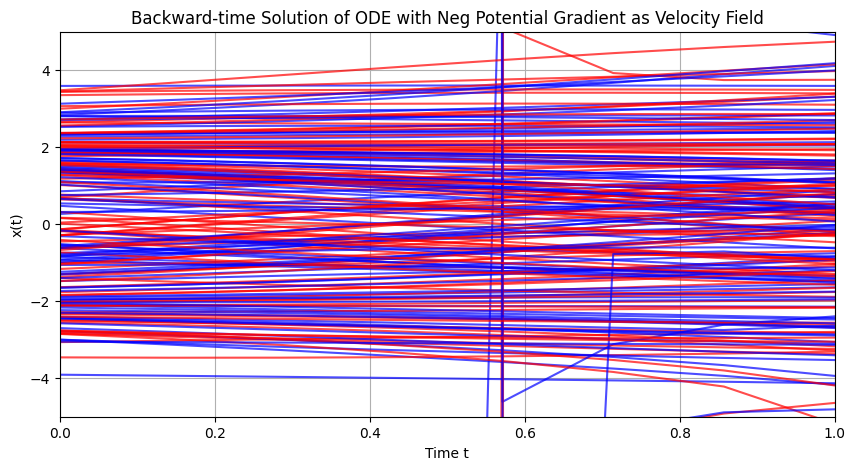

In [103]:
# Backward-time solution of ODE with neg potential gradient as velocity field 
# Batched initial conditions
# x0 = torch.tensor([[0.5, 0.5], [-0.5, -0.5], [0.0, 0.0]])  # Example batch of 3 initial points
x0 = generate_data(torch.tensor([0., 0.]), torch.eye(2) * 4., 100)

# Time points at which to solve the ODE
t = torch.linspace(1., 0., 8)  # 96 time points from 1 to 0

# Define func
def func(t, x):
    # Ensure batched input for the function
    return -1 * torch.stack([potential.grad(t, xi) for xi in x], dim=0)

# Solve the ODE using odeint for batched data
solution = odeint(func, x0, t, method='euler')

# Extract the solution for plotting
x_values = solution.detach().numpy()  # Convert to NumPy for plotting
t_values = t.numpy()  # Convert time points to NumPy

# Plot the solution for each initial condition in the batch
plt.figure(figsize=(10, 5))
for i in range(x0.shape[0]):  # Loop through each initial condition in the batch
    plt.plot(t_values, x_values[:, i, 0], label=f'x1(t) for x0[{i}]', alpha=0.7, color='red')
    plt.plot(t_values, x_values[:, i, 1], label=f'x2(t) for x0[{i}]', alpha=0.7, color='blue')
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Backward-time Solution of ODE with Neg Potential Gradient as Velocity Field')
plt.axis([0., 1., -5., 5.])
# plt.legend()
plt.grid(True)
plt.show()

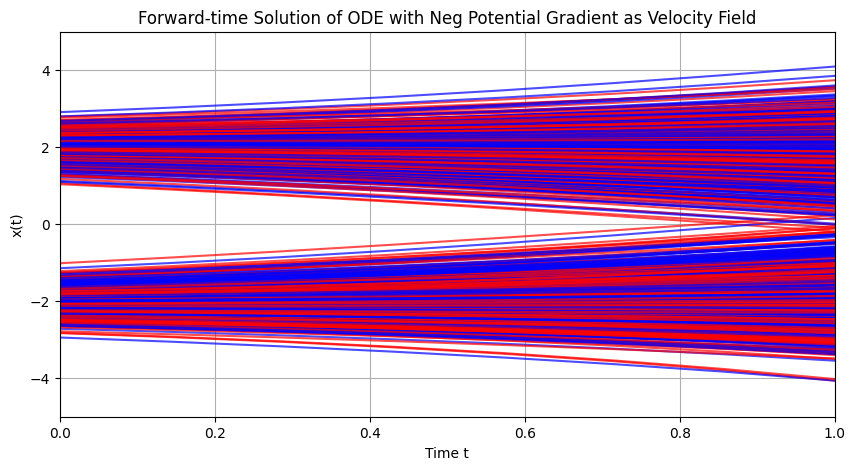

In [104]:
# Forward-time solution of ODE with neg potential gradient as velocity field 
# Batched initial conditions
# x0 = torch.tensor([[0.5, 0.5], [-0.5, -0.5], [0.0, 0.0]])  # Example batch of 3 initial points
x0 = data

# Time points at which to solve the ODE
t = torch.linspace(0., 1., 8)  # 96 time points from 1 to 0

# Define func
def func(t, x):
    # Ensure batched input for the function
    return -1 * torch.stack([potential.grad(t, xi) for xi in x], dim=0)

# Solve the ODE using odeint for batched data
solution = odeint(func, x0, t, method='euler')

# Extract the solution for plotting
x_values = solution.detach().numpy()  # Convert to NumPy for plotting
t_values = t.numpy()  # Convert time points to NumPy

# Plot the solution for each initial condition in the batch
plt.figure(figsize=(10, 5))
for i in range(x0.shape[0]):  # Loop through each initial condition in the batch
    plt.plot(t_values, x_values[:, i, 0], label=f'x1(t) for x0[{i}]', alpha=0.7, color='red')
    plt.plot(t_values, x_values[:, i, 1], label=f'x2(t) for x0[{i}]', alpha=0.7, color='blue')
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Forward-time Solution of ODE with Neg Potential Gradient as Velocity Field')
plt.axis([0., 1., -5., 5.])
# plt.legend()
plt.grid(True)
plt.show()

In [105]:
z_data = generate_data(torch.tensor([0., 0.]), torch.eye(2) * 4., 512)
z_pred = model_ot_flow(z_data, ts=torch.linspace(0, 1, 8), rtol=0.001, atol=0.000001, method='euler', backward=True)

(np.float64(-7.5), np.float64(7.5), np.float64(-7.5), np.float64(7.5))

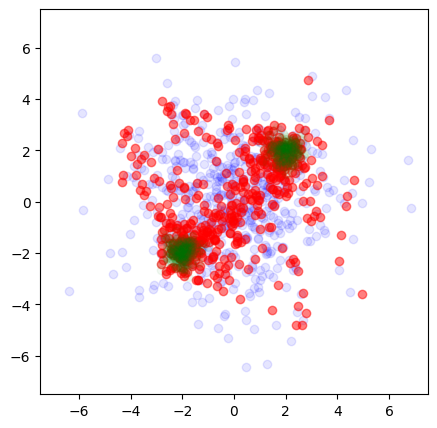

In [108]:
plt.figure(figsize=(5, 5))

plt.scatter(z_data[:, 0].detach().numpy(), z_data[:, 1].detach().numpy(), color='blue', alpha=0.1)
plt.scatter(z_pred[:, 0].detach().numpy(), z_pred[:, 1].detach().numpy(), color='red', alpha=0.5)
plt.scatter(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(), color='green', alpha=0.05)
plt.axis([-7.5, 7.5, -7.5, 7.5])

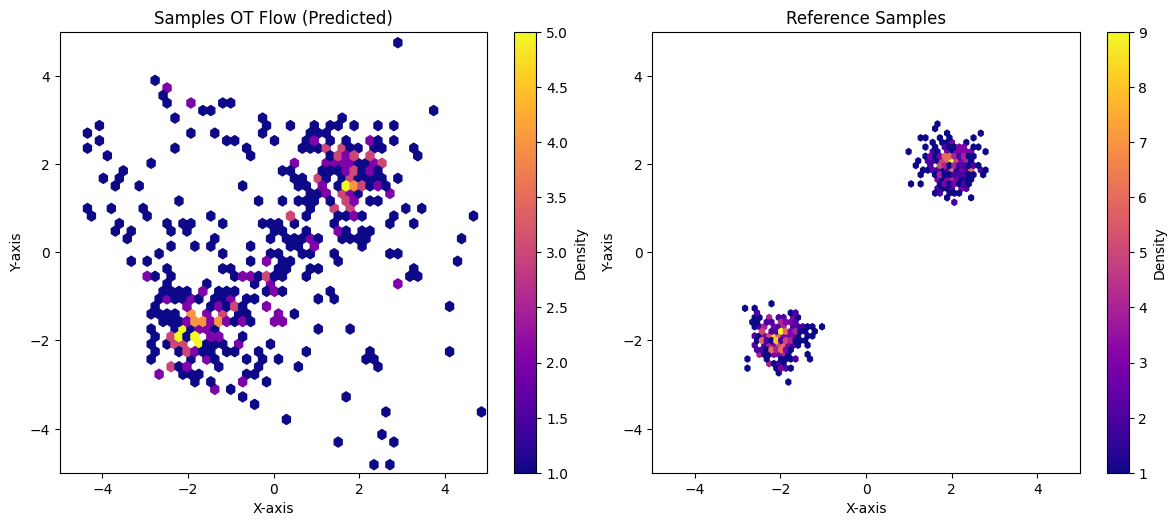

In [109]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.tight_layout()

# First hexbin plot
hb1 = axs[0].hexbin(z_pred[:, 0].detach().numpy(), z_pred[:, 1].detach().numpy(),
                    gridsize=50, cmap="plasma", mincnt=1)
cbar1 = fig.colorbar(hb1, ax=axs[0], label='Density')
axs[0].set_title("Samples OT Flow (Predicted)")
axs[0].set_xlabel("X-axis")
axs[0].set_ylabel("Y-axis")
axs[0].axis([-5, 5, -5, 5])

# Second hexbin plot
hb2 = axs[1].hexbin(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(),
                    gridsize=50, cmap="plasma", mincnt=1)
cbar2 = fig.colorbar(hb2, ax=axs[1], label='Density')
axs[1].set_title("Reference Samples")
axs[1].set_xlabel("X-axis")
axs[1].set_ylabel("Y-axis")
axs[1].axis([-5, 5, -5, 5])

# Show plot
plt.show()